In [74]:
import numpy as np
import pickle
import os
import pyimfit
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import angular_separation
import corner
import matplotlib.pyplot as plt
import pandas as pd
from photutils import profiles
from tqdm import tqdm
import logging
import warnings
from matplotlib.backends.backend_pdf import PdfPages
from astropy.visualization import simple_norm
warnings.filterwarnings('ignore')
from photutils.isophote import EllipseSample, Isophote
from photutils.isophote.sample import CentralEllipseSample
from photutils.isophote.fitter import CentralEllipseFitter
from photutils.isophote import build_ellipse_model,Ellipse, EllipseGeometry, IsophoteList
from matplotlib.ticker import FormatStrFormatter
import glob
import matplotlib.gridspec as gridspec
from photutils.aperture import EllipticalAperture
from photutils.detection import find_peaks
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo
import seaborn as sns

medium_font_size = 14 
plt.rcParams['font.size'] = medium_font_size
plt.rcParams['axes.labelsize'] = medium_font_size
plt.rcParams['axes.titlesize'] = medium_font_size
plt.rcParams['xtick.labelsize'] = medium_font_size
plt.rcParams['ytick.labelsize'] = medium_font_size
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'monospace'
# fl = os.listdir("../cutouts/data")
# agns = sorted([f[:-5] for f in fl if f[0]=="J"])

# make galaxy models
I_tot is the integrated intensity. Feeding position at 50,70 gives model image at 49,69

In [75]:
def find_highest_indices(arr):
    """returns a tuple of ys, xs - indices of pixels with highest counts"""
    flattened_arr = np.array(arr).flatten()
    max_indices = np.unravel_index(np.argsort(flattened_arr)[-2:], arr.shape)
    return max_indices

def crop_image(imageAGN, size=40):
    ysO,xsO = find_highest_indices(imageAGN)
    # find the center of AGNs
    ycO = int(np.sum(ysO)/2)
    xcO = int(np.sum(xsO)/2)
    # crop
    px=int(size/2)
    imageAGNcrop = imageAGN[ycO-px:ycO+px,xcO-px:xcO+px]
    # find agn centers in cropped image
    ys,xs = find_highest_indices(imageAGNcrop)
    return imageAGNcrop, ys, xs

def makeModelDict(PA_ss, ell_ss, n_ss, I_ss, r_ss, Itot,
                 PA_lim, ell_lim, I_lim,  Iss_lim, rss_lim, Itot_lim,
                 sigma, sigma_lim, Isky, Isky_lim,
                 h1,h2,h_lim,alpha,alpha_lim):
    """Return Sersic, PSF, and Gaussian model parameter dictionary"""
    # Sersic
    """sersic = {'PA': [PA_ss, PA_lim[0],PA_lim[1]], 'ell_bulge': [ell_ss, ell_lim[0],ell_lim[1]], 'n': [n_ss, 'fixed'],
    'I_e': [I_ss, Iss_lim[0],Iss_lim[1]], 'r_e': [r_ss, rss_lim[0],rss_lim[1]]}"""
    sersic = {'PA': [PA_ss, PA_lim[0],PA_lim[1]], 'ell_bulge': [ell_ss, ell_lim[0],ell_lim[1]], 'n': [n_ss, 0.3, 6],
    'I_e': [I_ss, Iss_lim[0],Iss_lim[1]], 'r_e': [r_ss, rss_lim[0],rss_lim[1]]}
    sersic_dict = {'name': "Sersic", 'label': "bulge", 'parameters': sersic}
    # PSF
    psf = {'I_tot' : [Itot, Itot_lim[0], Itot_lim[1]]}
    psf_dict = {'name': "PointSource", 'label': "psf", 'parameters': psf}
    # Rot psf
    psfRot = {'I_tot' : [Itot, Itot_lim[0], Itot_lim[1]], 'PA':[PA_ss, PA_lim[0],PA_lim[1]] }
    psfRot_dict = {'name': "PointSourceRot", 'label': "psf", 'parameters': psfRot}
    # Gaussians
    gaussian = {'PA':[PA_ss, PA_lim[0],PA_lim[1]], 'ell':[ell_ss, ell_lim[0],ell_lim[1]], 
                'I_0':[I_ss, Iss_lim[0],Iss_lim[1]], 'sigma':[sigma, sigma_lim[0], sigma_lim[1]]}
    gaussian_dict = {'name': "Gaussian", 'label': "gaussian", 'parameters': gaussian}
    # Flat sky
    flatsky = {'I_sky': [Isky, Isky_lim[0], Isky_lim[1]]}
    flatsky_dict = {'name': "FlatSky", 'label': "flat_sky", 'parameters':flatsky}
    # flat bar
    flatbar = {'PA':[PA_ss, PA_lim[0],PA_lim[1]], 'ell':[ell_ss, ell_lim[0],ell_lim[1]],
               'deltaPA_max':[PA_ss, PA_lim[0],PA_lim[1]], 'I_0':[I_ss, Iss_lim[0],Iss_lim[1]],
               'h1':[h1, h_lim[0],h_lim[1]], 'h2':[h2, h_lim[0],h_lim[1]], 
               'r_break':[r_ss, rss_lim[0],rss_lim[1]], 'alpha':[alpha,alpha_lim[0],alpha_lim[1]]}
    flatbar_dict = {'name': "FlatBar", 'label': "flat_bar", 'parameters':flatbar}
    # Exponential
    exponential = {'PA': [PA_ss, PA_lim[0],PA_lim[1]], 'ell': [ell_ss, ell_lim[0],ell_lim[1]], 
                   'I_0': [I_ss, Iss_lim[0],Iss_lim[1]], 'h': [h1, h_lim[0],h_lim[1]]}
    exp_dict = {'name': "Exponential", 'label': "disk", 'parameters':exponential}
    return sersic_dict, psf_dict, gaussian_dict, flatsky_dict, flatbar_dict,exp_dict
      
def galaxy_funcdict(X0, Y0, X1, Y1, Xss0, Yss0, Xss1, Yss1, 
                    Xlim, Ylim, Xsslim, Ysslim,
                    PA_ss, ell_ss, n_ss, I_ss, r_ss, Itot,
                    PA_lim, ell_lim, I_lim,  Iss_lim, rss_lim, Itot_lim,
                    sigma, sigma_lim, midf, Isky, Isky_lim,
                    h1,h2,h_lim,alpha,alpha_lim):
    """Returns a function set dictionary with keys as model name, 
       values as model function set"""
    sersic_dict, psf_dict, gaussian_dict, flatsky_dict, flatbar_dict,exp_dict = makeModelDict(PA_ss, ell_ss, n_ss, I_ss, r_ss, Itot,
                                                                                     PA_lim, ell_lim, I_lim,  Iss_lim, rss_lim, Itot_lim,
                                                                                     sigma, sigma_lim, Isky, Isky_lim,
                                                                                     h1,h2,h_lim,alpha,alpha_lim)
    #========function dictionary
    # psf
    funcset_dict_psf0 = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict]}
    funcset_dict_psf1 = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict]}
    # separate sersic
    funcset_dict_sersic0 = {'X0': [Xss0,Xsslim[0],Xsslim[1]], 'Y0': [Yss0,Ysslim[0],Ysslim[1]], 
                   'function_list': [sersic_dict]}
    funcset_dict_sersic1 = {'X0': [Xss1,Xsslim[0],Xsslim[1]], 'Y0': [Yss1,Ysslim[0],Ysslim[1]], 
                   'function_list': [sersic_dict]}
    # overall sersic
    funcset_dict_sersicT = {'X0': [midf,Xsslim[0],Xsslim[1]], 'Y0': [midf,Ysslim[0],Ysslim[1]], 
                   'function_list': [sersic_dict]}
    # same center psf+sersic
    funcset_dict_psfser0 = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict,sersic_dict]}
    funcset_dict_psfser1 = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict,sersic_dict]}
    # flat bar
    funcset_dict_flatbar = {'X0': [midf,Xlim[0],Xlim[1]], 'Y0': [midf, Ylim[0],Ylim[1]], 
                    'function_list': [flatbar_dict]}
    funcset_dict_psfserbar = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict,sersic_dict,flatbar_dict]}
    funcset_dict_psfbar0 = {'X0': [X0,Xlim[0],Xlim[1]], 'Y0': [Y0, Ylim[0],Ylim[1]], 
                    'function_list': [flatbar_dict,psf_dict]}
    funcset_dict_psfbar1 = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                    'function_list': [flatbar_dict,psf_dict]}
    funcset_dict_sersicbar = {'X0': [X1,Xlim[0],Xlim[1]], 'Y0': [Y1, Ylim[0],Ylim[1]], 
                    'function_list': [flatbar_dict,sersic_dict]}
    # exponential
    funcset_dict_exp = {'X0': [midf,Xlim[0],Xlim[1]], 'Y0': [midf, Ylim[0],Ylim[1]], 
                    'function_list': [exp_dict]}
    funcset_dict_psfexp = {'X0': [midf,Xlim[0],Xlim[1]], 'Y0': [midf, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict,exp_dict]}
    funcset_dict_psfserexp= {'X0': [midf,Xlim[0],Xlim[1]], 'Y0': [midf, Ylim[0],Ylim[1]], 
                    'function_list': [psf_dict,sersic_dict,exp_dict]}
    funcset_dict_serexp= {'X0': [midf,Xlim[0],Xlim[1]], 'Y0': [midf, Ylim[0],Ylim[1]], 
                    'function_list': [sersic_dict,exp_dict]}
    
    #========model dict
    funcset = {
        # 2 gals/cores
        "2sersic":[funcset_dict_sersic0,funcset_dict_sersic1],
        "1psf0,2sersic":[funcset_dict_psf0,funcset_dict_sersic0,funcset_dict_sersic1],
        "1psf1,2sersic":[funcset_dict_psf1,funcset_dict_sersic0,funcset_dict_sersic1],
        "1psf+sersic,1psf": [funcset_dict_psfser0,funcset_dict_psf1],
        "1psf+sersic,sersic": [funcset_dict_sersic1,funcset_dict_psfser0],
        "1psf+sersic,sersic,sersic": [funcset_dict_sersic1,funcset_dict_psfser0,funcset_dict_sersicT],
        "sersic,1psf+sersic": [funcset_dict_sersic0,funcset_dict_psfser1],
        "2psf": [funcset_dict_psf0, funcset_dict_psf1],
        "2psf+sersic,sameCenter": [funcset_dict_psfser0,funcset_dict_psfser1],
        "2psf+sersic,diffCenter":[funcset_dict_psf0, funcset_dict_psf1,funcset_dict_sersic0,funcset_dict_sersic1],
        "2psf,overall Sersic": [funcset_dict_psf0, funcset_dict_psf1,funcset_dict_sersicT],
        
        "1psf+sersic,bar":[funcset_dict_psfser1, funcset_dict_flatbar],
        "1psf,sersic,bar":[funcset_dict_psf1,funcset_dict_sersic0,funcset_dict_flatbar],
        "1psf+sersic+bar":[funcset_dict_psfserbar],
        "1psf,bar":[funcset_dict_psf0,funcset_dict_flatbar],
        "1psf+bar":[funcset_dict_psfbar0],
        "1sersic,bar":[funcset_dict_sersic0,funcset_dict_flatbar],
        "1sersic+bar":[funcset_dict_sersicbar],
        
        "1psf+bar,sersic":[funcset_dict_psfbar0, funcset_dict_sersic1],
        "1psf+bar,sersic0":[funcset_dict_psfbar0, funcset_dict_sersic0],
        "1psf+bar,1psf":[funcset_dict_psfbar0,funcset_dict_psf1],
        "1sersic+bar,1psf":[funcset_dict_psf0, funcset_dict_sersicbar],
        "1sersic+bar,sersic":[funcset_dict_sersicbar,funcset_dict_sersic0],
        "1psf+sersic,1psf+bar": [funcset_dict_psfbar0, funcset_dict_psfser0],
        "2psf+bar,sameCenter":[funcset_dict_psfbar0,funcset_dict_psfbar1],
       
        "1psf": [funcset_dict_psf0],
        "1psf+sersic": [funcset_dict_psfser0],
        "1psf+sersic,exp": [funcset_dict_psfser0,funcset_dict_exp],
        "1psf+sersic+exp": [funcset_dict_psfserexp],
        "psf,sersic+exp": [funcset_dict_serexp,funcset_dict_psf0],
        "sersic+exp":[funcset_dict_serexp],
        "psf+exp":[funcset_dict_psfexp]
    }
    return funcset

def galaxy_model(X0, Y0, X1, Y1, Xss0, Yss0, Xss1, Yss1, Xlim, Ylim, Xsslim, Ysslim,
                PA_ss, ell_ss, n_ss, I_ss, r_ss, Itot,
                PA_lim, ell_lim, I_lim,  Iss_lim, rss_lim, Itot_lim,
                sigma, sigma_lim,midf, Isky, Isky_lim,h1,h2,h_lim,alpha,alpha_lim):
    """return a dictionary of galaxy model with keys as model name"""
    funcset = galaxy_funcdict(X0, Y0, X1, Y1, Xss0, Yss0, Xss1, Yss1, Xlim, Ylim, Xsslim, Ysslim,
                    PA_ss, ell_ss, n_ss, I_ss, r_ss, Itot,
                    PA_lim, ell_lim, I_lim,  Iss_lim, rss_lim, Itot_lim,
                    sigma, sigma_lim,midf, Isky, Isky_lim,h1,h2,h_lim,alpha,alpha_lim);
    models = {}
    for model in funcset:
        models[model]= pyimfit.ModelDescription.dict_to_ModelDescription({'function_sets':funcset[model]});
    return models

def dofit_no_oversp(modelName, dataImage, psf, readnoise=0.22, expT=1, skylevel = 654.63, ncom=4, solver="NM",effgain=1):
    """do fit with not oversampled psf
       """
    fitter = pyimfit.Imfit(models_n1[modelName],psf=psf)
    fitter.loadData(dataImage,exp_time=expT, 
                    read_noise=readnoise, original_sky=skylevel,n_combined=ncom,gain=effgain)
    fitter.doFit(solver)
    fitConfig = fitter.getModelDescription()
    fitModelImage = fitter.getModelImage()
    fitResult = fitter.getFitResult()
    param_names = fitter.numberedParameterNames
    return fitConfig, fitModelImage, fitResult, param_names,fitter

def fit_multi(models,epsf):
    """fit all models in models
       return lists of model config, model images, fit results, and parameter names"""
    models = list(models.keys())
    configs = []
    modelIms = []
    fitResults = []
    pnames= []

    logging.basicConfig(filename='error.log', level=logging.ERROR, format='%(asctime)s - %(levelname)s - %(message)s')
    # fit all models
    for modelName in tqdm(models, desc="Fitting models"):
        try:
            config, modelIm, fitRes, pname = dofit_no_oversp(modelName, dataImage=imageAGNcrop, psf=epsf, solver="LM")
            configs.append(config)
            modelIms.append(modelIm)
            fitResults.append(fitRes)
            pnames.append(pname)
        except Exception as e:
            error_message = f"An error occurred for {modelName}: {e}"
            logging.error(error_message)
            print(error_message) 
            continue  
    return configs, modelIms, fitResults, pnames

def save_data(models,configs,modelIms,fitResults,pnames,filename):
    savedata = {}
    savedata['modelNames'] = models
    savedata['configs'] = configs
    savedata['modelImage'] = modelIms
    savedata['fitResults'] = fitResults
    savedata['paramNames'] = pnames
    pickle.dump(savedata,open(filename,"wb"))
    
def plot_fit(filename, figtitle):
    with open(filename, 'rb') as file:
        d = pickle.load(file)
    nrows=6
    ncols=3
    fig,ax = plt.subplots(nrows,ncols,figsize=(9,18))
    ax = ax.ravel()
    modelNum = len(d['fitResults'])
    fitStats = [d['fitResults'][i].fitStat for i in range(modelNum)]

    for i, j in zip(np.argsort(fitStats),np.arange(modelNum)):
        resi = imageAGNcrop-d['modelImage'][i]
        im = ax[j].imshow(resi,cmap="coolwarm")
        title = d['modelNames'][i]
        title = '\n'.join(title.split(',', 1)) if len(title) > 15 else title
        ax[j].set_title(title, fontsize=10)
        fig.colorbar(im, ax=ax[j], shrink=0.7)
        rmsNoise = np.sqrt(np.sum(resi**2)/imageAGNcrop.shape[0]**2)
        iRatio = np.sum(resi)/np.sum(imageAGNcrop)*100
        ax[j].text(0.05, 0.25, f"$\chi^2$:{fitStats[i]:.2f}", transform=ax[j].transAxes, fontsize=10, color='k')
        ax[j].text(0.05, 0.15, f"noise RMS:{rmsNoise:.2f}", transform=ax[j].transAxes, fontsize=10, color='k')
        ax[j].text(0.05, 0.05, f"% I_res: {iRatio:.2f}", transform=ax[j].transAxes, fontsize=10, color='k')
    # turn off empty axes
    empty_axes = nrows*ncols-modelNum
    [ax[-i].axis('off') for i in np.arange(1,empty_axes+1)]
    fig.suptitle(figtitle)
    fig.tight_layout();
       
def fit_df(filename):
    with open(filename, 'rb') as file:
        d = pickle.load(file)
    modelNum = len(d['fitResults'])
    pd.set_option('display.max_colwidth',1)
    best5i = np.argsort([d['fitResults'][i].fitStat for i in range(modelNum)])[:5]
    dfs = [pd.DataFrame([d['paramNames'][n],d['fitResults'][n].params],index=['',d['modelNames'][n]]).T for n in best5i]
    dfs = pd.concat(dfs, axis=1).fillna('')
    newcol = [' \n '.join(col.split(',', 1)) if len(col) > 15 else col for col in dfs.columns]
    dfs.columns = newcol
    return dfs

def ang_sep():
    w = WCS(imageFile)
    ra1,dec1 = w.pixel_to_world_values(dic['X0_2'],dic['Y0_2'])
    ra2,dec2 = w.pixel_to_world_values(dic['X0_2']+dic['r_e_4'],dic['Y0_2']+dic['r_e_4'])
    angular_separation(ra1,dec1,ra2,dec2)
    pass

def find_sky(imageAGNcrop, plothist=False):
    bgr = plt.hist(imageAGNcrop.flatten(),bins=np.arange(np.min(imageAGNcrop),20))
    plt.close()
    max_ind = np.where(bgr[0]==np.max(bgr[0]))[0][0]
    sky = (bgr[1][max_ind]+bgr[1][max_ind+1])/2
    if plothist:
        fig,ax = plt.subplots(1,2,figsize=(10,4))
        ax[0].hist(imageAGNcrop.flatten(),bins=np.arange(np.min(imageAGNcrop),np.max(imageAGNcrop)))
        ax[1].hist(imageAGNcrop.flatten(),bins=np.arange(np.min(imageAGNcrop),20))
        [ax[i].set_title(['Whole intensity range',f'sky level: {float(sky):.4f}'][i]) for i in range(2)]
        [ax[i].set_xlabel('intensity') for i in range(2)]
        ax[0].set_ylabel('number of agns') 
    return sky


In [97]:
def profile_1D(semiA,image,PA=180,ell=0.5):
    """make 1D elliptical profiles"""
    # create guess ellipse
    pos0 = image.shape[0]//2
    geometry = EllipseGeometry(x0=pos0, y0=pos0, sma=semiA, eps=ell,
                               pa=PA * np.pi / 180.0)
    # load image and geometry
    ellipse = Ellipse(image, geometry)
    # do isophote fit
    isolist = ellipse.fit_image()
    return isolist

def plot_isophotes(ax,isolist,num_aper=10):
    """plot aperatures on image"""
    for sma in np.linspace(isolist.sma[0],isolist.sma[-1],num_aper):
        iso = isolist.get_closest(sma)
        x, y, = iso.sampled_coordinates()
        ax.plot(x, y, color='white',linewidth="0.5")
        
def make_model_components(config,imshape):
    """make model component images from best fit config"""
    comp_names = config.functionLabelList()
    comp_ims=[]
    comp_pos = []
    for i in range(len(config.getModelAsDict()['function_sets'])):
        posX = config.getModelAsDict()['function_sets'][i]['X0']
        posY = config.getModelAsDict()['function_sets'][i]['Y0']
        functions = config.getModelAsDict()['function_sets'][i]['function_list']
        for j in range(len(functions)):
            if functions[j]['label'] =="bulge n=1" or functions[j]['label'] =="bulge n=4":
                functions[j]['parameters']['n'].append("fixed")
            funcset_dict = {'X0': posX, 'Y0': posY, 'function_list': [functions[j]]}
            model_dict = {'function_sets': [funcset_dict]}
            model = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict)
            imfit_fitter = pyimfit.Imfit(model,epsf)
            comp_ims.append(imfit_fitter.getModelImage(shape=(imshape,imshape)))
            comp_pos.append([posX[0],posY[0]])
    return comp_ims, comp_pos, comp_names

def plot_model_components(comp_ims,comp_names,comp_pos,isolist_comps, colormap="ch:s=-.3,r=.6", plotIso=False,shrink_ratio=0.5):
    """plot 2D model components and check residual with model image"""
    clmap = sns.color_palette(colormap, as_cmap=True)
    ncom = len(comp_names)
    fig,ax = plt.subplots(nrows=1,ncols=ncom+1, figsize=(ncom*4,3))
    im = [ax[i].imshow(comp_ims[i],norm='symlog',cmap=clmap) for i in range(ncom)]
    [ax[i].text(0.05, 0.05, f"(x,y)=({comp_pos[i][0]:.1f},{comp_pos[i][1]:.1f})", transform=ax[i].transAxes, fontsize=8, color='k') for i in range(ncom-1)]
    [ax[i].set_title(comp_names[i]) for i in range(ncom)]
    im.append(ax[-1].imshow(np.sum(comp_ims[:-1],axis=0)-comp_ims[-1],norm='symlog',cmap=clmap))
    ax[-1].set_title("model-comps")
    [fig.colorbar(im[i], ax=ax[i], shrink=shrink_ratio).ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) for i in range(len(ax))]
    if plotIso:
        for i in range(len(isolist_comps)):
             plot_isophotes(ax[i],isolist_comps[i],num_aper=5)
    fig.tight_layout();


def fit_stat_1d(iso_data,iso_model,nparams,cut=0.8):
    """calculate 1d chi squared, cut to 80% of data"""
    cut_index = int(np.round(len(iso_data.sma)*cut))
    sma_cut = iso_data.sma[cut_index]
    diff = iso_data.intens[1:cut_index]-iso_model.intens[1:cut_index]
    chi_square1d_reduced = np.sum((diff/iso_data.rms[1:cut_index])**2)/(cut_index-nparams)
    diff_full = iso_data.intens[1:]-iso_model.intens[1:]
    chi_square1d_full_reduced = np.sum((diff_full/iso_data.rms[1:])**2)/(len(iso_data)-1-nparams)
    return chi_square1d_reduced,sma_cut,chi_square1d_full_reduced


def plot_1isophote(ax,sma,isolist):
    """plot aperatures on image"""
    iso = isolist.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    ax.plot(x, y, color='white',linewidth="0.3")


def pix_to_arcsec(imageFile,framelim):
    w = WCS(imageFile)
    # convert pixel to degree
    ra1,dec1 = w.pixel_to_world_values(0,0)
    ra2,dec2 = w.pixel_to_world_values(framelim,framelim)
    framelim_deg = angular_separation(ra1*u.degree,dec1*u.degree,ra2*u.degree,dec2*u.degree)
    # find pixel-arsec scale
    framelim_arcsec = framelim_deg.to('arcsec')
    arcsec_per_pix = framelim_arcsec/framelim
    return arcsec_per_pix, [ra1,dec1,ra2,dec2]

def surface_brightness(intensity, area, magZPT):
    return -2.5*np.log10(intensity/area)+ magZPT


def radial_plot_params(imageFile, framelim, isolist_data,isolist_comps,hdu_exp,z=0.2):
    # convert pixel to arcsec and kpc
    arcsec_per_pix, skycoords = pix_to_arcsec(imageFile,framelim)
    sma_arcsec = isolist_data.sma*arcsec_per_pix
    sma_kpc = (cosmo.angular_diameter_distance(z)*sma_arcsec.to('rad').value).to('kpc')
    # calculate isophote areas and find surface brightness
    areas = (np.sqrt((1-isolist_data.eps**2)*sma_arcsec**2)*np.pi*sma_arcsec).value
    magZPT = hdu_exp.header['MAGZP']
    mu_data = [surface_brightness(i,areas,magZPT) for i in [isolist_data.intens,isolist_data.intens-isolist_data.int_err,isolist_data.intens+isolist_data.int_err]]
    mu_models = [[surface_brightness(i,areas,magZPT) for i in [isolist_comps[j].intens,isolist_comps[j].intens-isolist_comps[j].int_err,isolist_comps[j].intens+isolist_comps[j].int_err]] for j in range(len(isolist_comps))]
    return sma_arcsec, sma_kpc, mu_data, mu_models, skycoords
    

def plot_everything(on,image,m,modelname,comp_names,fsr,sma_arcsec,sma_kpc,mu_data,mu_models,skycoords,colormap):
    colors = sns.color_palette(colormap, len(comp_names)+2)[1:]
    linestyles = ['-', '--', '-.', ':']
    #colors = sns.color_palette("colorblind", len(comp_names)+2)
    cmapp = sns.color_palette(colormap, as_cmap=True).reversed()
    # Create grid and add subplots
    fig = plt.figure(figsize=(14, 4),layout='tight')
    gs = gridspec.GridSpec(2, 4, height_ratios=[3, 1], width_ratios=[1.25,1.25,1,1.5],hspace=0.05,wspace=0.05)
    ax1 = fig.add_subplot(gs[:, 0],xlabel='RA (deg)',ylabel='DEC (deg)') 
    ax2 = fig.add_subplot(gs[:, 1],xticks=[],yticks=[])
    ax3 = fig.add_subplot(gs[:, 2],xticks=[],yticks=[])
    ax4a = fig.add_subplot(gs[0, 3]) 
    ax4b = fig.add_subplot(gs[1, 3])   
    # formatting ticks
    xticks = np.linspace(skycoords[0],skycoords[2],4)
    yticks = np.linspace(skycoords[1],skycoords[3],4)
    ax1.set_xticks(np.linspace(0,image.shape[0],4))
    ax1.set_yticks(np.linspace(0,image.shape[0],4))
    ax1.set_xticklabels([f'{x:.3f}' for x in xticks])
    ax1.set_yticklabels([f'{y:.3f}' for y in yticks],rotation=90)
    ax1.tick_params(direction='in')
    # plot 2d and colorbars
    ax = [ax1,ax2,ax3,ax4a,ax4b]
    im = [ax[i].imshow([image, m][i], norm='symlog',cmap=cmapp) for i in range(2)]
    im2 = ax[2].imshow(image-m,cmap=cmapp)
    fig.colorbar(im2,ax=ax[2],orientation='horizontal',location='bottom',pad=0.05)
    fig.colorbar(im[1],ax=[ax[0],ax[1]],orientation='vertical',location='right',shrink=0.5)
    [ax[i].set_title([on,f"Model:\n{modelname}",f'Residual,$\chi^2_r$={fsr:.2f}'][i]) for i in range(3)]
    # radial plot data
    ax[3].plot(sma_arcsec[1:],mu_data[0][1:],label="data",c=colors[-1])
    ax[3].fill_between(sma_arcsec[1:].value,mu_data[1][1:],mu_data[2][1:],color=colors[-1],alpha=0.5)
    # radial plot model
    #ax[3].plot(sma_arcsec[1:],mu_models[-1][0][1:],label="model",c=colors[-2],linestyle="dashdot")
    #ax[3].fill_between(sma_arcsec[1:].value, mu_models[-1][1][1:],mu_models[-1][2][1:],color=colors[-2],alpha=0.5)
    # radial plot components
    [ax[3].plot(sma_arcsec[1:],mu_models[i][0][1:],label=comp_names[i],linestyle=linestyles[i],c=colors[i]) for i in range(len(comp_names)-1)]
    [ax[3].fill_between(sma_arcsec[1:].value,mu_models[i][1][1:],mu_models[i][2][1:],color=colors[i],alpha=0.5) for i in range(len(comp_names)-1)]
    ax[4].plot(sma_kpc[1:],mu_data[0][1:]-mu_models[-1][0][1:],c=colors[-2],linestyle="dashdot")
    ax[4].fill_between(sma_kpc[1:].value,mu_data[1][1:]-mu_models[-1][1][1:],mu_data[2][1:]-mu_models[-1][2][1:],color=colors[-2],alpha=0.5)
    ax[4].axhline(y=0,linestyle='--',c=colors[1],lw=1)
    # format ticks
    ax[3].invert_yaxis()
    ax[3].set_xlabel("R[arcsec]")
    ax[3].set_ylabel("$\mu$ [mag arcsec$^{-2}$]")
    ax[3].xaxis.set_label_position('top') 
    ax[3].xaxis.set_ticks_position('top') 
    ax[3].legend(fontsize=10,loc='upper right',bbox_to_anchor=(1.6, 1))
    
    ax[4].set_xlabel("R[kpc]")
    ax[4].set_ylabel("$\Delta \mu$") 
    ax[4].set_ylim((-0.5,0.5))
    [ax.yaxis.set_label_position('right') for ax in [ax4a,ax4b]]
    [ax.yaxis.set_ticks_position('right') for ax in [ax4a,ax4b]];


def make_model_isophotes(isolist_data, comp_ims, comp_names, midf):
    isolist_comps=[]
    circ = [comp_names[i]=='psf' for i in range(len(comp_names))]
    for i in range(len(comp_ims)):
        isolist_ = []
        for iso in isolist_data[1:]:
            g = iso.sample.geometry
            ell = 0 if circ[i] else g.eps
            gn = EllipseGeometry(g.x0,g.y0, g.sma, ell, g.pa)
            sample = EllipseSample(comp_ims[i],g.sma,geometry=gn)
            sample.update()
            iso_ = Isophote(sample,0,True,0)
            isolist_.append(iso_)
        isolist = IsophoteList(isolist_)
        g = EllipseGeometry(midf,midf, 0.0, 0., 0.)
        sample = CentralEllipseSample(comp_ims[i], 0., geometry=g)
        fitter = CentralEllipseFitter(sample)
        center = fitter.fit()
        isolist.append(center)
        isolist.sort()
        isolist_comps.append(isolist)
    return isolist_comps

def make_data_isophotes(data,sma,midf):
    isolist_data = profile_1D(semiA=sma,image=data)
    # discard first isophote and make new
    isolist_data = isolist_data[1:]
    g = EllipseGeometry(midf,midf, 0.0, 0., 0.)
    sample = CentralEllipseSample(data, 0., geometry=g)
    fitter = CentralEllipseFitter(sample)
    center = fitter.fit()
    isolist_data.append(center)
    isolist_data.sort()
    return isolist_data

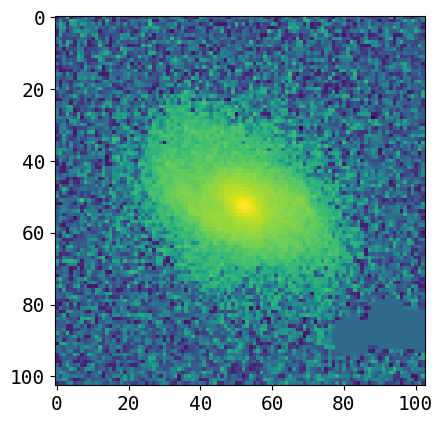

In [77]:
def make_peak_tbl(image,intens,agn_mask_size=35):
    """mask out agn and find peaks"""
    s = image.shape[0]
    midf = int(s//2)
    # mask out central agn
    peak_mask = np.zeros((s,s))
    #peak_mask[midf-agn_mask_size:midf+agn_mask_size,midf-agn_mask_size:midf+agn_mask_size] = 1
    peak_mask[:82,:]=1
    # convert to boolean
    peak_mask = peak_mask==1
    # detect peaks
    peak_tbl = find_peaks(image,threshold=intens,mask=peak_mask)
    return peak_tbl


def make_mask(image,pos,aper_radius,pa=180):
    """make a mask provided position and aperture radius"""
    aper0 = EllipticalAperture(pos,aper_radius,aper_radius,pa)
    aper_mask0 = aper0.to_mask()
    mask0 = aper_mask0.to_image(image.shape)
    return mask0

def mask_image(image,rad,intens,agn_mask_size,PA=180):
    """create mask and masked images"""
    peak_tbl = make_peak_tbl(image,intens,agn_mask_size)
    mask=[]
    # make masks
    for i in range(len(peak_tbl)):
        mask.append(make_mask(image,pos = [peak_tbl[i]['x_peak'],peak_tbl[i]['y_peak']],aper_radius=rad,pa=PA))
    # sum all masks
    mask = np.sum(mask,axis=0)
    # make masked image
    masked_im = np.where(mask==0,image,0)
    return masked_im

on = "J0323+0018"
with open(os.path.expanduser("/home/insepien/research-data/agn-result/fit/final_fit_nb/"+on+".pkl"),"rb") as f:
    d = pickle.load(f)
imageAGN = d['imageSS']

plt.imshow(mask_image(image=imageAGN,rad=5,intens=4,agn_mask_size=50), norm='symlog')
imageAGN_masked = mask_image(image=imageAGN,rad=5,intens=4,agn_mask_size=50)


In [60]:
fits.writeto("~/research-data/agn-result/fit/fit_masked_n.3to6/masked_image_SS/"+on+".fits",imageAGN_masked, overwrite=True)

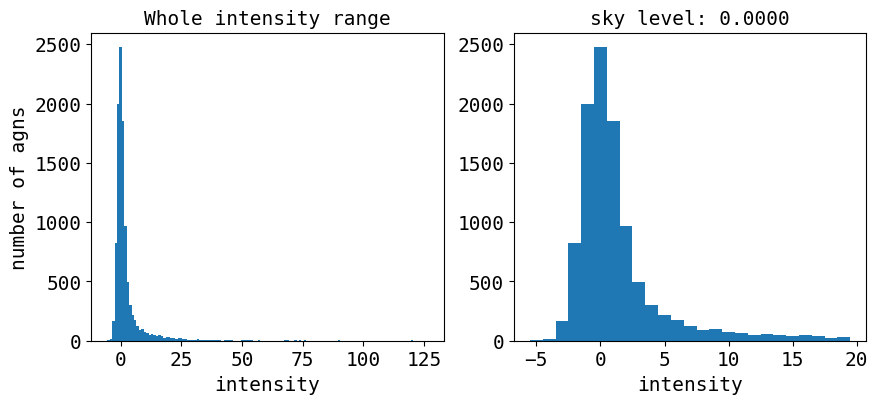

In [78]:
on = "J0323+0018"

with open(os.path.expanduser("/home/insepien/research-data/agn-result/fit/final_fit_nb/"+on+".pkl"),"rb") as f:
    d = pickle.load(f)
imageAGN = d['imageSS']
imageFile = glob.glob(os.path.expanduser("~/research-data/agn-result/box/final_cut/"+on+"*"))[0]
#imageAGN = fits.getdata(os.path.expanduser(imageFile))
with open(os.path.expanduser("~/research-data/psf-results/psf_pkls/psf_"+on+".pkl"),"rb") as f:
    d = pickle.load(f)
epsf = d['psf'].data

# cropping image and find centers
#imageAGN, ys, xs = crop_image(imageAGN,size=10)
ys,xs = find_highest_indices(imageAGN)
Imax = imageAGN.max()
itot=1500
framelim = imageAGN.shape[0]
midF=framelim//2

# for testing 1 model at a time
def make1model(xpos,ypos,function_dict,psf,dataImage):
    func_set_dict = {'X0': xpos, 'Y0': ypos, 
                    'function_list': [function_dict]}
    funcset = [func_set_dict]
    model= pyimfit.ModelDescription.dict_to_ModelDescription({'function_sets':funcset})
    fitter = pyimfit.Imfit(model,psf=psf)
    return fitter


sersic_dict, psf_dict, gaussian_dict, flatsky_dict, flatbar_dict, exp_dict = makeModelDict(PA_ss=200, ell_ss=0.1, n_ss=1, I_ss=1, r_ss=20, Itot=itot,
                                                                     PA_lim=[0,360], ell_lim=[0.0,1.0], I_lim=[0.1,Imax],
                                                                     Iss_lim=[0.1,Imax], rss_lim=[0.1,framelim], Itot_lim=[0.1,1e4],
                                                                     sigma = 5, sigma_lim = [1,20], Isky = 2.5, Isky_lim =[0,10],
                                                                     h1=10,h2=10,h_lim=[0.1,framelim],alpha=0.1,alpha_lim=[0.1,framelim])


# make models
hlim_max=1000
models_n1 = galaxy_model(X0=xs[0], Y0=ys[0], 
                         X1=xs[1], Y1=ys[1], 
                         Xss0=xs[0], Yss0=ys[0], 
                         Xss1=xs[1], Yss1=ys[1],
                         Xlim=[0,framelim], Ylim=[0,framelim], Xsslim = [0,framelim], Ysslim=[0,framelim],
                         PA_ss=200, ell_ss=0.1, n_ss=1, I_ss=1, r_ss=20, Itot=itot,
                         PA_lim=[0,360], ell_lim=[0.0,1.0], I_lim=[0.1,Imax],
                         Iss_lim=[0.1,Imax], rss_lim=[0.1,framelim], Itot_lim=[0.1,1e4],
                         sigma = 5, sigma_lim = [1,20],midf=midF, Isky = 2.5, Isky_lim =[0,10],
                         h1=10,h2=10,h_lim=[0.1,hlim_max],alpha=0.1,alpha_lim=[0.1,framelim])

sky = find_sky(imageAGN,plothist=True)


Text(0.5, 1.0, 'J0323+0018')

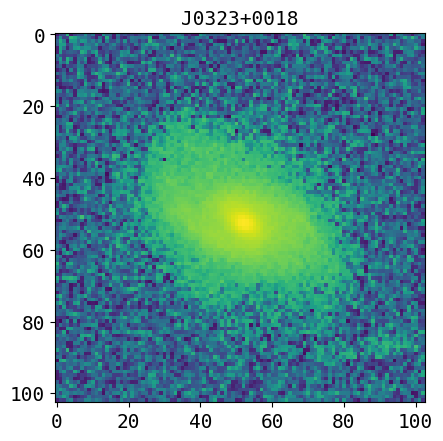

In [79]:
plt.imshow(imageAGN, norm='symlog')
plt.title(on)
# plt.plot(midF,midF,"ko",markersize=1)


In [80]:
def _dofit_no_oversp(model, dataImage, psf, readnoise=0.22, expT=1, skylevel = 654.63, ncom=4, solver="NM",effgain=1):
    """do fit with not oversampled psf
       """
    fitter = pyimfit.Imfit(model,psf=psf)
    if float(ncom)==1.:
        fitter.loadData(dataImage,exp_time=expT, 
                    read_noise=readnoise, original_sky=skylevel,gain=effgain)
    else:
        fitter.loadData(dataImage,exp_time=expT, 
                    read_noise=readnoise, original_sky=skylevel,n_combined=ncom,gain=effgain)
    fitter.doFit(solver)
    fitConfig = fitter.getModelDescription()
    fitModelImage = fitter.getModelImage()
    fitResult = fitter.getFitResult()
    param_names = fitter.numberedParameterNames
    return fitConfig, fitModelImage, fitResult, param_names,fitter


Imax = imageAGN.max()
itot=1700
sersic_dict, psf_dict, gaussian_dict, flatsky_dict, flatbar_dict, exp_dict = makeModelDict(PA_ss=30, ell_ss=0.1, n_ss=1, I_ss=1, r_ss=20, Itot=itot,
                                                                     PA_lim=[0,360], ell_lim=[0.0,1.0], I_lim=[0.1,Imax],
                                                                     Iss_lim=[0.1,Imax], rss_lim=[0.1,framelim], Itot_lim=[0.1,1e4],
                                                                     sigma = 5, sigma_lim = [1,20], Isky = 2.5, Isky_lim =[0,10],
                                                                     h1=10,h2=10,h_lim=[0.1,framelim],alpha=0.1,alpha_lim=[0.1,framelim])
broken_exponentialParamsDict = {'PA': [0, 0,360], 'ell': [0.5, 0,1], 'I_0': [10.0, 0.0,Imax], 
                                'h1': [10, 0.1,framelim],'h2': [10, 0.1,framelim],'r_break': [10, 0.1,framelim],'alpha':[0.5,0,100]}
bexp_dict = {'name': "BrokenExponential", 'label': "bexp", 'parameters':broken_exponentialParamsDict}

GaussianRingAzParamsDict = {'PA': [40, 0,360], 'ell': [0.5, 0,1], 'A_maj':[100,0,framelim], 'A_min_rel':[0.5,0,1],
                          'R_ring':[10,0,100],'sigma_r':[5,0,100]}
gausR_dict = {'name': "GaussianRingAz", 'label': "GaussianRingAz", 'parameters': GaussianRingAzParamsDict}

exponentialParamDict = {'PA': [160, 0,360], 'ell': [0.5, 0,1], 'I_0': [1, 0.1,Imax], 'h': [1, 0.1,1e4]}
exp2_dict = {'name': "Exponential", 'label': "disk", 'parameters':exponentialParamDict}

flatbar = {'PA':[30,0,360], 'ell':[0.1,0,1],
            'deltaPA_max':[30,0,360], 'I_0':[1,0,Imax],
            'h1':[10,0.1,framelim], 'h2':[10,0.1,framelim,], 
            'r_break':[20,0,framelim], 'alpha':[0.1,0,framelim]}
flatbar0_dict = {'name': "FlatBar", 'label': "flat_bar", 'parameters':flatbar}


sersicParamsDict = {'PA': [160, 0, 360], 'ell_bulge': [0.5, 0, 1],
                    'n': [1, 0.3,6],'I_e': [1, 0.0,Imax], 'r_e': [3, 0.0, framelim]}
sersic2_dict = {'name': "Sersic", 'label': "bulge 2", 'parameters': sersicParamsDict}

sersic1_dict = {'name': "Sersic", 'label': "bulge 1", 'parameters': sersicParamsDict}

sersic3ParamsDict = {'PA': [30, 0, 360], 'ell_bulge': [0.1, 0, 1],
                    'n': [1,  0.5,5],'I_e': [10, 0.0,Imax], 'r_e': [15, 0.0, framelim]}
sersic3_dict = {'name': "Sersic", 'label': "bulge 3", 'parameters': sersic3ParamsDict}

ext_sersicParamsDict = {'PA': [10, 0, 360], 'ell_bulge': [0.1, 0, 1],
                    'n': [1,  0.5,5],'I_e': [1, 0.0,Imax], 'r_e': [3, 0.0, framelim]}
sersic_ext_dict = {'name': "Sersic", 'label': "ext bulge", 'parameters': ext_sersicParamsDict}


funcset_dict_sersic1= {'X0': [midF,0,framelim], 'Y0': [midF,0,framelim], 
                    'function_list': [exp2_dict,psf_dict]}
funcset_dict_sersic2= {'X0': [midF-1,0,framelim], 'Y0': [midF-1,0,framelim], 
                    'function_list': [sersic2_dict]}
funcset_dict_sersic3= {'X0': [53,0,framelim], 'Y0': [33,0,framelim], 
                    'function_list': [sersic_ext_dict]}



model_dict = {'function_sets': [funcset_dict_sersic1,funcset_dict_sersic2]}
model = pyimfit.ModelDescription.dict_to_ModelDescription(model_dict)

ModelObjectWrapper: about to call _model.CreateModelImage()...
ModelObjectWrapper: about to call _model.CreateModelImage()...
ModelObjectWrapper: about to call _model.CreateModelImage()...
X0_1: 52.00 
Y0_1: 54.61 
I_tot_1: 0.10 
X0_2: 52.69 
Y0_2: 53.13 
PA_2: 125.50 
ell_bulge_2: 0.00 
n_2: 4.00 
I_e_2: 5.90 
r_e_2: 15.24 
PA_3: 130.27 
ell_bulge_3: 0.00 
n_3: 1.00 
I_e_3: 0.10 
r_e_3: 3.65 
15


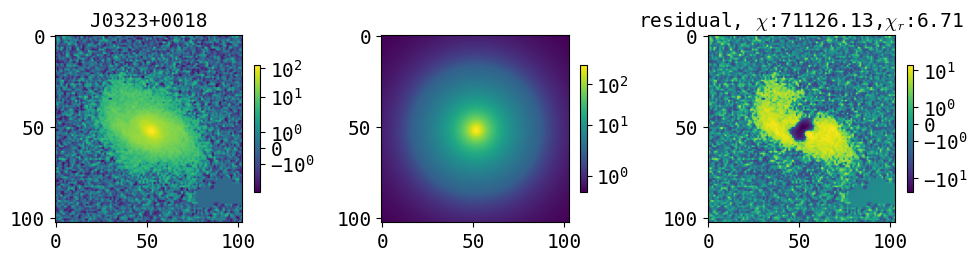

In [100]:
mosfile = glob.glob(os.path.expanduser("~/raw-data-agn/mos-fits-agn/*"+on+"*.mos.fits"))[0]
expfile = glob.glob(os.path.expanduser("~/raw-data-agn/exp-fits-agn/*"+on+"*.exp.fits"))[0]
with fits.open(os.path.expanduser(mosfile)) as hdul:
    hdu0 = hdul[0]

sky_level = hdu0.header['BACKGND'] #fits:[e-/s] native pixels, pf: value should be in the same units as the data pixels

with fits.open(os.path.expanduser(expfile)) as hdul:
    hdu = hdul[0]
exptime= hdu.header['EXPOSURE'] # fits: actual exp time, pf: total integration time
gain = hdu.header['EGAIN'] #fits: no unit specified, pf: in electrons/ADU
noise=hdu.header['EFFRN'] #fits:[e-], pf: in electrons
numcom=hdu.header['NCOADD'] #Number of Averaged Frames   
# Try for only 1 model
image = imageAGN_masked
config0, modelIm0, fitRes0, pname0,fitter0  = _dofit_no_oversp(model,dataImage=image, psf=epsf,solver="LM",
                                                 readnoise=noise, expT=exptime, skylevel = sky_level, ncom=numcom,effgain=gain)
m = modelIm0
res = fitRes0.params
pname = pname0
fs = fitRes0.fitStat
fsr = fitRes0.fitStatReduced
comp_ims, comp_pos, comp_names = make_model_components(config0,imshape=image.shape[0])
comp_ims.append(m)
comp_names.append("model")
comp_pos.append([midF,midF])
[print(f"{pname0[i]}: {fitRes0.params[i]:.2f} ") for i in range(len(fitRes0.params))];
fig,ax = plt.subplots(1,3,figsize=(10,3))
#ax[0].imshow(imageAGN_bs-comp_ims[0],norm='symlog')
#ax[1].imshow(np.sum(comp_ims,axis=0)-comp_ims[0],norm='symlog')
im0 = ax[0].imshow(image,norm='symlog')
im1=ax[1].imshow(np.sum(comp_ims,axis=0),norm='symlog')
im2=ax[2].imshow(image-m,norm='symlog')
[fig.colorbar([im0,im1,im2][i],ax=ax[i],shrink=0.5) for i in range(3)]
ax[0].set_title(on)
ax[1].set_title("")
ax[2].set_title(f'residual, $\chi$:{fs:.2f},$\chi_r$:{fitRes0.fitStatReduced:.2f}')
fig.tight_layout();
print(len(fitRes0.params))
#plot_model_components(comp_ims,comp_names,comp_pos,isolist_comps,shrink_ratio=0.3)

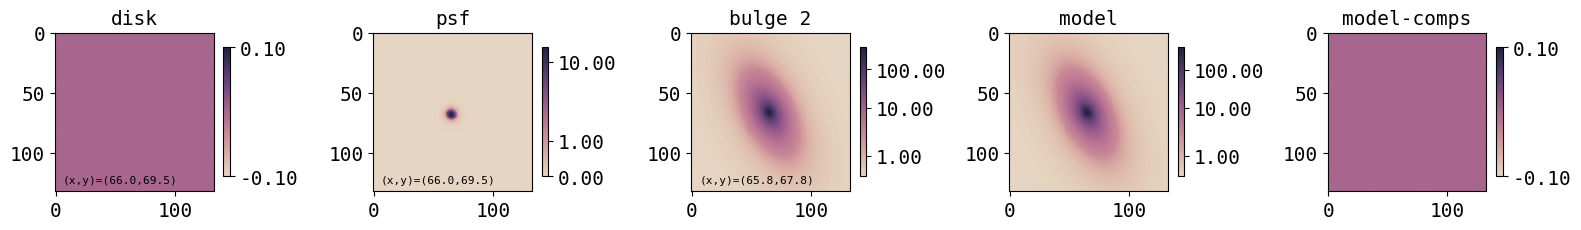

In [139]:
plot_model_components(comp_ims,comp_names,comp_pos,isolist_comps)

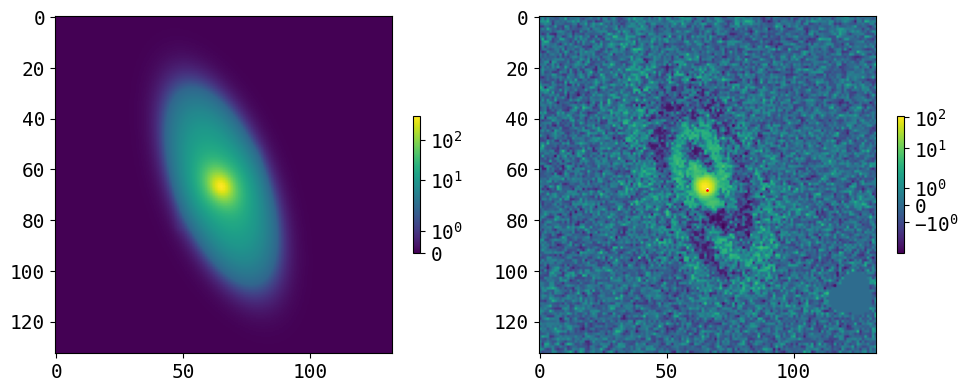

In [99]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
im0=ax[0].imshow(m,norm='symlog')
im1=ax[1].imshow(image-comp_ims[0]-comp_ims[2],norm='symlog')
[fig.colorbar([im0,im1][i],ax=ax[i],shrink=0.4) for i in range(2)]
fig.tight_layout();
ax[1].plot(comp_pos[2][0],comp_pos[2][1],"wo",markersize=1)
ax[1].plot(comp_pos[1][0],comp_pos[1][1],"ro",markersize=1)
# ax[1].plot(80,135,"ro",markersize=1)
#ax[1].plot(40,40,"ro",markersize=1)
#[print(f"{pname0[i]}: {fitRes0.params[i]:.2f} ") for i in range(len(fitRes0.params))];

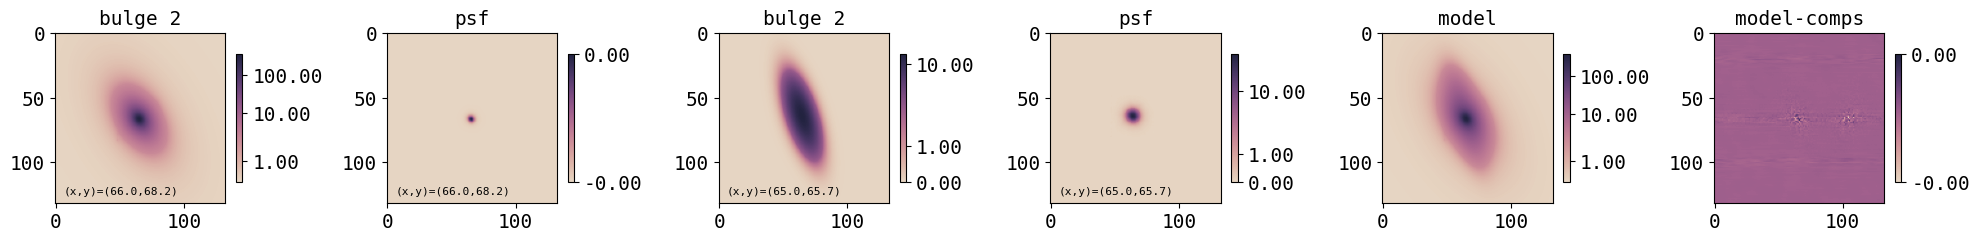

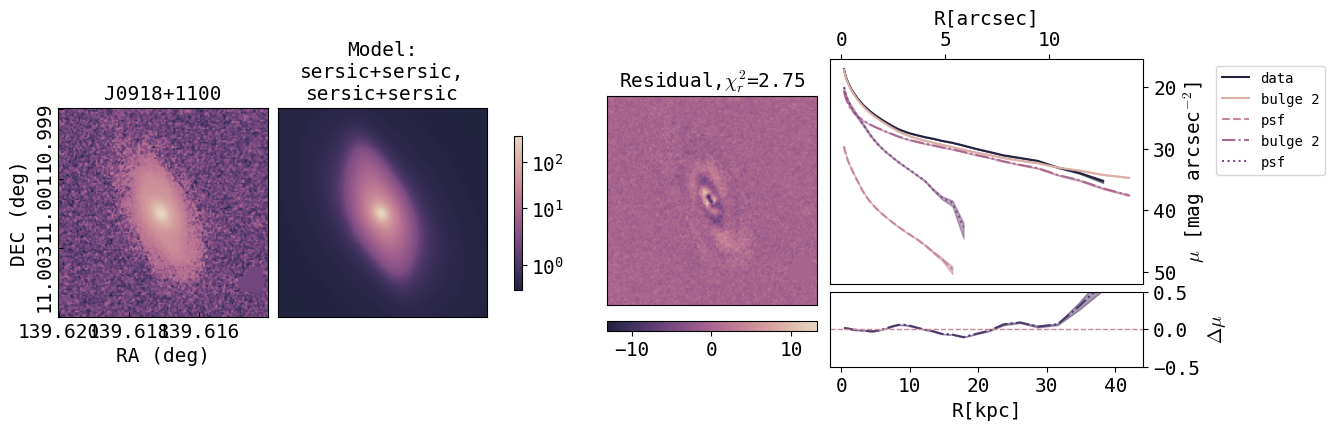

In [88]:
modelname = 'sersic+sersic,\nsersic+sersic'
isolist_data = make_data_isophotes(image,10,midF)
isolist_comps = make_model_isophotes(isolist_data,comp_ims,comp_names,midF)  
plot_model_components(comp_ims,comp_names,comp_pos,isolist_comps)
sma_arcsec, sma_kpc, mu_data,mu_models,skycoords = radial_plot_params(imageFile, framelim,isolist_data,isolist_comps,hdu_exp=hdu0,z=0.2)
plot_everything(on,image,m,modelname,comp_names,fsr,sma_arcsec,sma_kpc,mu_data,mu_models,skycoords,colormap="ch:s=-.3,r=.6")

In [ ]:
def save_data(modelname,image,model,configs,modelIms,fitResults,pnames,objectName):
    outDir = os.path.expanduser("~/research-data/agn-result/fit/final_fit_nb")
    d = {}
    d[modelname] = model
    savedata = {}
    savedata['imageSS'] = image
    savedata['modelNames'] = d
    savedata['configs'] = configs
    savedata['modelImage'] = modelIms
    savedata['fitResults'] = fitResults
    savedata['paramNames'] = pnames
    filename = os.path.join(outDir, objectName+".pkl")
    #filename = os.path.join(outDir, objectName+"_bulges.pkl")pickle.dump(savedata,open(os.path.expanduser(filename),"wb"))
    

save_data(modelname,image=image, model=model,configs=[config0],modelIms=[modelIm0],fitResults=[fitRes0],pnames=pname0,objectName=on)



chi_r:2.11218
X0_1:53.16
Y0_1:53.51
PA_1:126.84
ell_bulge_1:0.40
n_1:0.30
I_e_1:6.12
r_e_1:21.20
PA_2:312.13
ell_bulge_2:0.54
n_2:1.49
I_e_2:92.22
r_e_2:2.78
X0_2:52.87
Y0_2:53.68
PA_3:98.04
ell_bulge_3:0.47
n_3:0.30
I_e_3:12.94
r_e_3:12.96
PA_4:0.00
ell_bulge_4:1.00
n_4:1.43
I_e_4:6.78
r_e_4:1.47


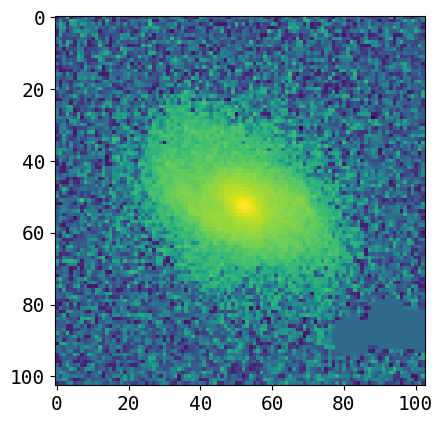

In [71]:
from modelComponents import modelComps
on = "J0323+0018"
fit_path = "/home/insepien/research-data/agn-result/fit/fit_masked_n.3to6/masked_fit/"+on+".pkl"
comp_path = "/home/insepien/research-data/agn-result/fit/fit_masked_n.3to6/masked_fit_comp/"+on+"_comp.pkl"

with open(os.path.expanduser(fit_path),"rb") as f:
    d_fit = pickle.load(f)
#with open(os.path.expanduser(comp_path),"rb") as f:
#    d_comp = pickle.load(f)

modelname = 'sersic+sersic,sersic+sersic'
# print parameters
ind = np.where(np.array(list(d_fit['modelNames'].keys()))==modelname)[0][0]
print(f"chi_r:{d_fit['fitResults'][ind].fitStatReduced:.5f}")
[print(f"{d_fit['paramNames'][ind][i]}:{d_fit['fitResults'][ind].params[i]:.2f}") for i in range(len(d_fit['paramNames'][ind]))];

plt.imshow(d_fit['imageSS'],norm='symlog')

In [62]:
from scipy.stats import chi2

def cal_pval(i,j,sig_lev=0.05):
    """check if models fit equally well (null hypothesis)
        calculate p-value given 2 row indices in summary df using difference in chi2 and dof
        compare with significance level, default 0.05, to reject null"""
    del_dof = np.abs(df.loc[i,"dof"] - df.loc[j,"dof"])
    del_chi = np.abs(df.loc[i,'chi2'] - df.loc[j,'chi2'])
    df.at[i,"del chi"] = del_chi
    df.at[i,"reject null"] = (1 - chi2.cdf(del_chi,del_dof)) < sig_lev

# get chi2, model name, dof to a df
n = len(d_fit['fitResults'])
chisq = np.round([d_fit['fitResults'][i].fitStat for i in range(n)])
modelnames = list(d_fit['modelNames'].keys())
dofs = [len(d_fit['fitResults'][i].params) for i in range(n)]
df = pd.DataFrame(data=[modelnames,dofs,chisq], index=['model', "dof",'chi2']).T
# get index of the nested model, i.e the 9th model is nested in model of row 10, 7 nested in 9, etc.
nest_dict = {0: None,
            1: 0.0,
            2: 1.0,
            3: 2.0,
            4: 2.0,
            5: 1.0,
            6: 1.0,
            7: 1.0,
            8: 7.0,
            9: 0.0,
            10: 1.0,
            11: 9,
            12: 11}
df['nests ind'] = list(nest_dict.values())
# check if model at index k fit equally well as model with index in "nests ind"
df['del chi'] = None
df['reject null'] = None
for k in range(1,n):
    cal_pval(k, df.loc[k,"nests ind"])
# sort 
df.sort_values(by='chi2')


,model,dof,chi2,nests ind,del chi,reject null
12,"sersic+sersic,sersic+sersic",24,22357.0,11.0,17984.0,True
4,"psf,sersic+sersic(n1)",15,24215.0,2.0,3405.0,True
6,sersic(1)+sersic+psf,13,24244.0,1.0,3417.0,True
10,"psf+sersic,sersic",15,24282.0,1.0,3379.0,True
3,"psf,sersic+exp",14,26038.0,2.0,1582.0,True
2,"psf,sersic",10,27620.0,1.0,41.0,True
1,psf+sersic,8,27661.0,0.0,9154.0,True
0,sersic,7,36815.0,NaN,None,None
11,"sersic+sersic,sersic",19,40341.0,9.0,20938.0,True
8,"psf+sersic,psf+sersic",16,40404.0,7.0,37134.0,True


In [ ]:
# write intensity to df
def get_magnitudes(row):
    """calculate magnitude from flux
        returns magnitude of all components in model"""
    oname = row['Obj Name']
    imageFile = glob.glob(os.path.expanduser("/home/insepien/research-data/agn-result/box/final_cut/"+oname+"*"))[0]
    with fits.open(imageFile) as f:
        mzpt = f[0].header['MAGZP']
    pnames = list(row.param_vals_best.keys())
    return [-2.5 * np.log10(row.param_vals_best[p]) + mzpt for p in pnames if p[0]=="I" ]

In [102]:
df2 = pd.read_pickle("/home/insepien/research-data/separation.pkl")
oname = "J1222-0007"
ind = df2[df2['Obj Name'] == oname].index[0]
for key, value in df2.loc[ind,"param_vals_best"].items():
    print(f"{key}: {value:.1f}")
sep=df2.loc[ind,"separation"][1].value
print(f"separation: {sep:.2f} kpc")

X0_1: 65.6
Y0_1: 66.2
PA_1: 142.5
ell_bulge_1: 0.5
n_1: 7.3
I_e_1: 35.3
r_e_1: 7.9
PA_2: 214.5
ell_bulge_2: 0.2
n_2: 0.2
I_e_2: 59.2
r_e_2: 4.8
X0_2: 95.4
Y0_2: 61.5
PA_3: 322.7
ell_bulge_3: 0.8
n_3: 0.1
I_e_3: 100.7
r_e_3: 3.7
PA_4: 0.0
ell_bulge_4: 0.3
n_4: 10.0
I_e_4: 200.5
r_e_4: 2.4
separation: 14.31 kpc


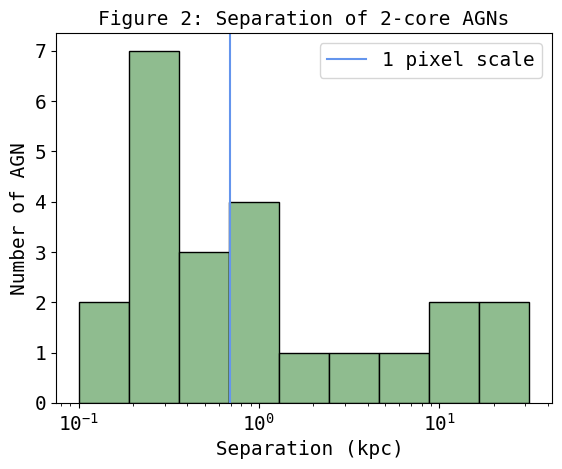

In [19]:
df2 = pd.read_pickle("/home/insepien/research-data/separation.pkl")
alpaka = pd.read_pickle("/home/insepien/research-data/alpaka41.pkl")

# find scale of 1 pixel
def pix_to_arcsec(imageFile):
    """convert pixel to arcsec"""
    w = WCS(imageFile)
    # convert pixel to degree
    framelim = fits.getdata(imageFile).shape[0]
    ra1,dec1 = w.pixel_to_world_values(0,0)
    ra2,dec2 = w.pixel_to_world_values(framelim,framelim)
    framelim_deg = angular_separation(ra1*u.degree,dec1*u.degree,ra2*u.degree,dec2*u.degree)
    # find pixel-arsec scale
    framelim_arcsec = framelim_deg.to('arcsec')
    arcsec_per_pix = framelim_arcsec/framelim
    return arcsec_per_pix, [ra1,dec1,ra2,dec2]
on = "J0820+1801"
imf = glob.glob(os.path.expanduser("~/research-data/agn-result/box/final_cut/"+on+"*"))[0]
arcsec_per_pix, _ = pix_to_arcsec(imf)
median_z = np.median(list(alpaka['Z']))
pix_in_kpc = (arcsec_per_pix.to(u.rad).value*cosmo.angular_diameter_distance(median_z)).to(u.kpc)

# get separations and plot
df2.drop(index=7, axis=0, inplace=True)
seps = df2['separation']
sep_kpc = [seps[i][1].value for i in range(len(seps)) if (i!=14) and (i!=7)]
sep_kpc.append(seps[14][0][1].value)
sep_kpc.append(seps[14][1][1].value)
plt.hist(sep_kpc, color='darkseagreen',edgecolor='k', bins=np.logspace(-1,1.5,10))
plt.axvline(x=pix_in_kpc.value,label="1 pixel scale",c='cornflowerblue')
plt.title("Figure 2: Separation of 2-core AGNs")
plt.xlabel(" Separation (kpc)")
plt.ylabel("Number of AGN")
plt.xscale('log')
plt.legend();

In [97]:
def find_agn_in_bin(bin_num):
    bins = np.logspace(-1,1.5,10)
    bin0_inds = np.where((bins[bin_num] <= sep_kpc) & (sep_kpc <= bins[bin_num+1]))
    bin0_agns = df2.loc[[i if i<14 else i+1 for i in bin0_inds[0]]]
    return bin0_agns

find_agn_in_bin(7)

,Obj Name,best model,comp fit,param_vals_best,separation,sersic index,I1,I2,OIII_5007_LUM_DERRED,I1/I2,OIII_BOL_2,OIII_BOL_1,I3,OIII_BOL_3
8,J0932+1611,"sersic+sersic,sersic",1,"{'X0_1': 72.38695276029446, 'Y0_1': 74.1128398...","(2.8831261941667834 arcsec, 9.625696937992078 ...","[2.8886457253698574, 0.21399972715785726, 1.14...","[2.4893245429420974, 9.769281974146095, 204.22...",[312.31958348159384],4.341364e+43,2.960027,8.770373e+45,2.596054e+46,NaN,NaN
16,J1222-0007,"sersic+sersic,sersic+sersic",,"{'X0_1': 65.61375398969572, 'Y0_1': 66.2397138...","(4.833296489654177 arcsec, 16.136597598468054 ...","[7.327116827501657, 0.16944882621807303, 0.050...","[35.252351150922614, 59.18040417567266]","[100.66879615521862, 200.5225138239295]",1.921846e+42,0.313531,1.170492e+45,3.669852e+44,NaN,NaN


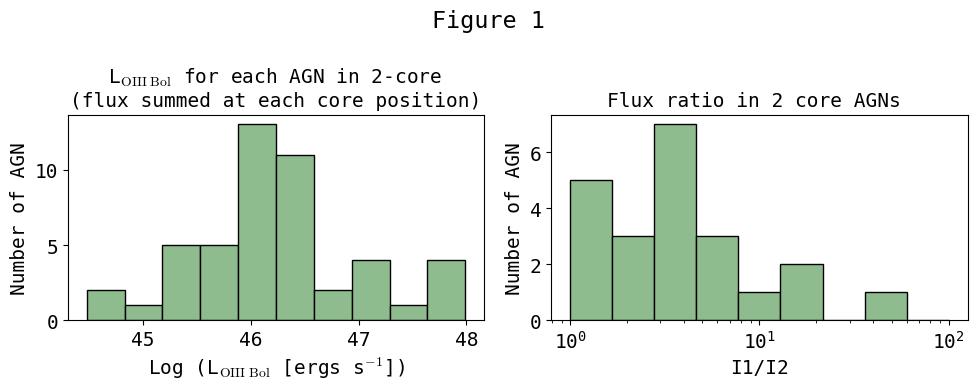

In [21]:
df_bol = pd.read_pickle("/home/insepien/research-data/oiiiBol.pkl")
def plot_Lbol(df):
    Lbol_2core = list(np.concatenate([df['OIII_BOL_1'],df['OIII_BOL_2']]))
    logbol = np.log10(Lbol_2core)
    fig,ax = plt.subplots(1,2,figsize=(10,4))
    ax[0].hist(np.log10(Lbol_2core), bins=np.linspace(np.min(logbol), np.max(logbol),11),edgecolor="black",color="darkseagreen")
    ax[0].set_xlabel("Log (L$_{\mathrm{OIII \ Bol}}$ [ergs s$^{-1}$])")
    ax[0].set_ylabel("Number of AGN")
    ax[0].set_title("L$_{\mathrm{OIII \ Bol}}$ for each AGN in 2-core \n(flux summed at each core position)")

    ax[1].hist([x if x>1 else 1/x for x in df['I1/I2'] ],edgecolor="black",color="darkseagreen",bins=np.logspace(0,2,10))
    ax[1].set_title("Flux ratio in 2 core AGNs ")
    ax[1].set_xlabel("I1/I2")
    ax[1].set_ylabel("Number of AGN")
    ax[1].set_xscale('log')
    fig.suptitle('Figure 1')
    fig.tight_layout()

plot_Lbol(df_bol)

In [22]:
len(df_bol)

24

In [ ]:
on = "J0926+0724"
a = alpaka[alpaka['Names']==on]['OIII_5007_LUM_DERRED'].values
print(f"alpaka ratio: {1/(a[0]/a[1]):.2e}")
b = 1/(df2[df2['Obj Name'] == on]['I1/I2'].values[0])
print(f"fit ratio: {b:.2e}")

# dup measurements 
dup = [(alpaka[alpaka['Names'] == df2.loc[j,"Obj Name"]]['OIII_5007_LUM_DERRED'].values).shape[0] for j in range(len(df2))]
dupped = np.where(np.array(dup)==2)
dupnames = df2.loc[dupped[0],"Obj Name"].values
alpaka[(alpaka['Names'] == dupnames[0]) & (alpaka['AGN_TYPE'] == 2)]['OIII_5007_LUM_DERRED']

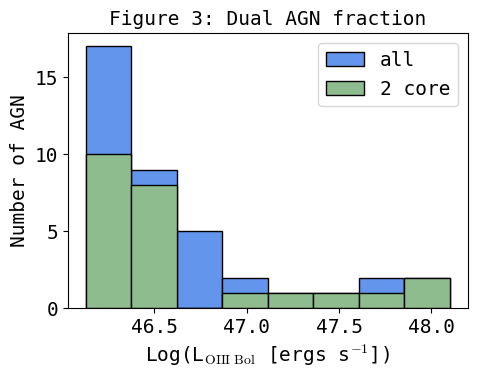

In [203]:
# load all sample df and get OIII lum
df_all = pd.read_pickle(os.path.expanduser("/home/insepien/research-data/all_results.pkl"))
alpaka = pd.read_pickle("/home/insepien/research-data/alpaka41.pkl")

# add corrected bolometric luminosity
df_all["OIII_5007_LUM_DERRED"] = None
for j in range(len(df_all)):
    name_mask = alpaka['Names'] == df_all.loc[j,"Obj Name"]
    type_mask  = alpaka['AGN_TYPE'] == 2
    oiiilum = alpaka[name_mask & type_mask]['OIII_5007_LUM_DERRED'].values
    df_all.at[j,"OIII_5007_LUM_DERRED"] = np.sum(oiiilum)
df_all['OIII_BOL'] = df_all['OIII_5007_LUM_DERRED']*800

# make luminosity bin and get dual fraction
log_lum_all = np.log10(list(df_all['OIII_BOL']))
log_bin = np.linspace(np.min(log_lum_all), np.max(log_lum_all) ,9)
lum_2 = df_all['OIII_BOL']
log_lum_2 = np.log10(list(df_all[df_all['Type']=='2']['OIII_BOL']))


# plot dual fraction by luminosity
fig,ax = plt.subplots(figsize=(5,4))
ax.hist(log_lum_all, bins=log_bin, color="cornflowerblue", label='all', edgecolor='k')
ax.set_xlabel("Log(L$_{\mathrm{OIII \ Bol}}$ [ergs s$^{-1}$])")
ax.set_ylabel("Number of AGN")
ax.set_title("Figure 3: Dual AGN fraction")

ax.hist(log_lum_2, bins=log_bin, color="darkseagreen",stacked=True, label="2 core", edgecolor='k')
ax.legend()
fig.tight_layout();

In [205]:
## J1010 CHECKS
from astropy.coordinates import SkyCoord
from astropy.table import Table
data = fits.getdata('/home/insepien/research-data/alpaka/ALPAKA_v1.fits')
def find1010(final_table):
    """find j1010 in alpaka"""
    for i in range(0, len(final_table)):
        pos = SkyCoord(ra=final_table['RA'][i]*u.deg, dec=final_table['DEC'][i]*u.deg)
        posstring = pos.to_string('hmsdms').split(' ')
        des_ra = posstring[0][0:2]+posstring[0][3:5]
        des_dec = posstring[1][0:3]+posstring[1][4:6]
        des = 'J'+des_ra+des_dec
        if des == "J1010+1413":
            return i
ind = find1010(data) 
# get j1010 row
j1010 = Table(data).to_pandas().loc[ind].to_dict()
lums = [i for i in list(j1010.keys()) if 'LUM' in i]

# OIII
ja_oiii = 1.2e44 # different from alpaka value??
i1 = ja_oiii*800/(1+1.3)
i2 = i1*1.3
print(f"alpaka OIII lum extinction corrected: {j1010['OIII_5007_LUM_DERRED']:.1e}")
print(f"paper OIII lum: {ja_oiii:.1e}")
print(f"by paper lum, core 1 bolometric: {i1:.1e}, core 2 bolometric: {i2:.1e}")

# IR
f160 = 3.23e-12*u.erg/u.s/(u.cm)**2 # from paper
ja_ir = 1.1e10
da = cosmo.luminosity_distance(j1010['Z'])
print(f"paper IR lum: {ja_ir:.1e}")
print(f"IR Lum: {(f160*4*np.pi*da**2).to(u.L_sun):.1e}")

alpaka OIII lum extinction corrected: 1.3e+43
paper OIII lum: 1.2e+44
by paper lum, core 1 bolometric: 4.2e+46, core 2 bolometric: 5.4e+46
paper IR lum: 1.1e+10
IR Lum: 9.8e+10 solLum


In [216]:
# import mean SED data
import requests
from io import StringIO
from astropy.constants import c
# URL of Kwarczyk mean SED
url = "https://content.cld.iop.org/journals/0067-0049/206/1/4/revision1/apjs468686t2_mrt.txt"
# Sending a GET request to the URL
response = requests.get(url)
# read header part and data part
header = '\n'.join((response.text).split("\n")[9:30])
# missing last row
data = '\n'.join((response.text).split("\n")[35:-3])
# Make SED table
df_header = pd.read_fwf(StringIO(header), colspecs="infer", header=None)
df_header.dropna(inplace=True)
df_data = pd.read_fwf(StringIO(data), colspecs="infer", header=None)
df_data.rename(columns=df_header[3],inplace=True)
# get j band stats


In [223]:
def sed_lum(wl):
    """given wavelength find luminosity in SED"""
    freq = (c/wl).to(u.Hz)
    log_freq = np.log10(freq.value)
    mask = [(df_data.loc[i,"lognu"]<= log_freq) & (log_freq <= df_data.loc[i+1,"lognu"]) for i in range(len(df_data)-1)]
    ind = np.where(np.array(mask) == True)[0][0]
    sed_logL = df_data.loc[ind,'All']
    return sed_logL

# wavelength values
wl_15 = 15e-6*u.m
#wl_j = 1.2e-6*u.m
wl_j = 6e-6*u.m
# find SED lum
sed_lum_j = sed_lum(wl_j)
sed_lum_corr = sed_lum(wl_15)
# convert to midIR lum
lum_j = 1.1e11*u.Lsun
lum_15 = (lum_j/sed_lum_j*sed_lum_corr).to(u.L_sun)


In [225]:
from scipy.optimize import fsolve
def f(Lbol,c1,k1,c2,k2,Lband):
    return Lbol/Lband - c1*(Lbol/1e10)**k1 + c2*(Lbol/1e10)**k2

Lbol = fsolve(f,x0=lum_15.value*10,args=(4.361,-0.361,11.4,-0.0063,lum_15.value))
(Lbol*u.L_sun).to(u.erg/u.s)

<Quantity [4.20857275e+45] erg / s>